## Non-Neural Modeling

This notebook picks up from our data_load_clean notebook. It uses the csv built there to do some modeling work with non-neural models, especially with Naive Bayesian models. 

### Imports and Mounting Drive

In [1]:
# this cell mounts drive, sets the correct directory, then imports all functions
# and relevant libraries via the functions.py file
from google.colab import drive
import sys

# install relevent libraries not included with colab
!pip install lime
!pip install symspellpy

drive.mount('/gdrive',force_remount=True)

drive_path = '/gdrive/MyDrive/Colab_Projects/Phil_NLP'

sys.path.append(drive_path)

     |████████████████████████████████| 276kB 5.4MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283846 sha256=c801b14e6f21492b8b5ab2d3a6715aaf227411e19453d291886ec0769e04ff79
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime
     |████████████████████████████████| 2.6MB 6.0MB/s 
Mounted at /gdrive


In [2]:
from functions import *
%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Load the data

In [3]:
df = pd.read_csv('/gdrive/MyDrive/Colab_Projects/Phil_NLP/phil_nlp.csv')

df.sample(5)

,title,author,school,sentence_spacy,sentence_str,sentence_length,sentence_lowered,tokenized_txt,lemmatized_str
155484,Lewis - Papers,Lewis,analytic,So it would be no surprise to find out that we...,So it would be no surprise to find out that we...,50,so it would be no surprise to find out that we...,"['so', 'it', 'would', 'be', 'no', 'surprise', ...",so -PRON- would be no surprise to find out th...
206674,Difference And Repetition,Deleuze,continental,The word 'id' a in this sense is not only a pr...,The word 'id' a in this sense is not only a pr...,196,the word 'id' a in this sense is not only a pr...,"['the', 'word', 'id', 'in', 'this', 'sense', '...",the word ' -PRON- would ' a in this sense be ...
76763,Aristotle - Complete Works,Aristotle,aristotle,Now such unanimity is found among good men; fo...,Now such unanimity is found among good men; fo...,365,now such unanimity is found among good men; fo...,"['now', 'such', 'unanimity', 'is', 'found', 'a...",now such unanimity be find among good man ; f...
28066,Plato - Complete Works,Plato,plato,"I won't grudge you this, Solon,' the priest re...","I won't grudge you this, Solon,' the priest re...",54,"i won't grudge you this, solon,' the priest re...","['won', 'grudge', 'you', 'this', 'solon', 'the...","-PRON- will not grudge -PRON- this , Solon , ..."
202692,Writing And Difference,Derrida,continental,And a conception of difference is attached les...,And a conception of difference is attached les...,78,and a conception of difference is attached les...,"['and', 'conception', 'of', 'difference', 'is'...",and a conception of difference be attach less...


### Baseline NB Bayes Model

In [33]:
# split the data
x_train, x_test, y_train, y_test = train_test_split(df['sentence_str'], df['school'])

In [34]:
# vectorize
tfidvectorizer = TfidfVectorizer(decode_error='ignore', stop_words=[])
tf_idf_data_train = tfidvectorizer.fit_transform(x_train)
tf_idf_data_test = tfidvectorizer.transform(x_test)

In [35]:
# build the classifier, train it, get predictions
nb_classifier = MultinomialNB()
nb_classifier.fit(tf_idf_data_train, y_train)
nb_classifier_preds = nb_classifier.predict(tf_idf_data_test)

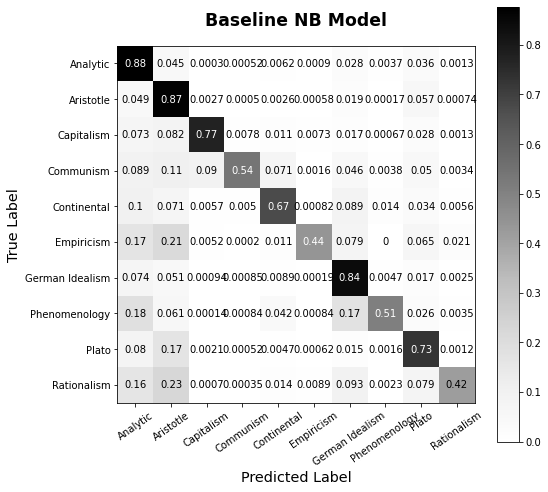

In [36]:
plot_pretty_cf(nb_classifier, tf_idf_data_test, y_test, title='Baseline NB Model')

In [37]:
print(classification_report(y_test, nb_classifier_preds))

                 precision    recall  f1-score   support

       analytic       0.63      0.88      0.74     13341
      aristotle       0.60      0.87      0.71     12115
     capitalism       0.86      0.77      0.82      4494
      communism       0.95      0.54      0.69      4457
    continental       0.85      0.67      0.75      8529
     empiricism       0.94      0.44      0.60      4981
german_idealism       0.69      0.84      0.76     10591
  phenomenology       0.93      0.51      0.66      7181
          plato       0.70      0.73      0.72      9606
    rationalism       0.90      0.42      0.57      5740

       accuracy                           0.72     81035
      macro avg       0.81      0.67      0.70     81035
   weighted avg       0.76      0.72      0.71     81035



Accuracy in the low 70s over 10 classes is not too bad, but we can at least aim higher than this. If we look at it, a lot of failures were along the lines of lines of class imbalance. 

In [10]:
df['school'].value_counts(normalize=True)

analytic           0.164882
aristotle          0.150487
german_idealism    0.129996
plato              0.118440
continental        0.104217
phenomenology      0.088150
rationalism        0.070803
empiricism         0.061489
capitalism         0.056130
communism          0.055405
Name: school, dtype: float64

Perhaps correcting for class imbalance could improve the model. 

### NB Corrected for Class Imbalance

Here we will use imblearn's over and undersampler to correct for class imbalance.

In [38]:
x_train, x_test, y_train, y_test = train_test_split(df['sentence_str'], df['school'])

In [39]:
tfidvectorizer = TfidfVectorizer(decode_error='ignore', stop_words=[])
tf_idf_data_train = tfidvectorizer.fit_transform(x_train)
tf_idf_data_test = tfidvectorizer.transform(x_test)

In [40]:
# to use the sampler, the data must be numerical
y_train_dummies = pd.get_dummies(y_train)
y_classes = y_train_dummies.idxmax(1, skipna=False)

le = LabelEncoder()
le.fit(list(y_classes))
y_integers = le.transform(list(y_classes))

# create a dict of labels : their integer representations
label_dict = dict(zip(y_classes, y_integers))
flipped_dict = {value:key for key, value in label_dict.items()}

# # get the class weights
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
sample_weights = compute_sample_weight('balanced', y_integers)
class_weights_dict = dict(zip(le.transform(list(le.classes_)), class_weights))

# convert the target to the numerical categories
y_train = y_train.apply(lambda x: label_dict[x])
y_test = y_test.apply(lambda x: label_dict[x])

#### Oversampling

In [41]:
ros = RandomOverSampler(sampling_strategy='all')

In [42]:
x_under, y_under = ros.fit_sample(tf_idf_data_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [43]:
nb_undersampled = MultinomialNB()
nb_undersampled.fit(x_under, y_under)
nb_undersampled_preds = nb_undersampled.predict(tf_idf_data_test)

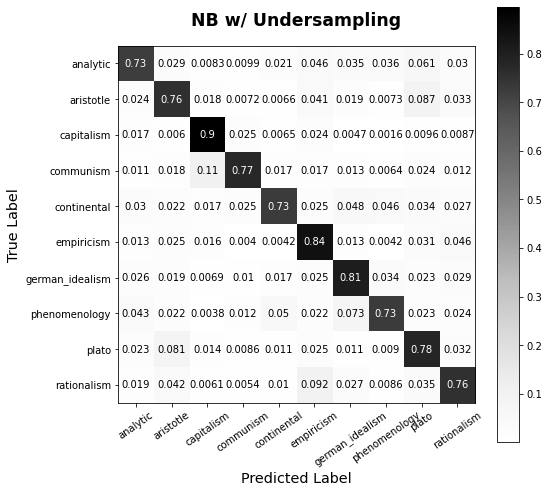

In [44]:
plot_pretty_cf(nb_undersampled, tf_idf_data_test, y_test, 
               title='NB w/ Undersampling', label_dict=flipped_dict)

In [45]:
print(classification_report(y_test, nb_undersampled_preds))

              precision    recall  f1-score   support

           0       0.85      0.73      0.78     13245
           1       0.81      0.76      0.78     12267
           2       0.76      0.90      0.82      4494
           3       0.80      0.77      0.79      4497
           4       0.84      0.73      0.78      8444
           5       0.61      0.84      0.71      5006
           6       0.81      0.81      0.81     10506
           7       0.78      0.73      0.75      7157
           8       0.71      0.78      0.75      9634
           9       0.67      0.76      0.71      5785

    accuracy                           0.77     81035
   macro avg       0.76      0.78      0.77     81035
weighted avg       0.78      0.77      0.77     81035



Not bad, we got a sold increase in accuracy. Let's check if oversampling helps any more.

#### Undersampling

In [46]:
rus = RandomUnderSampler(sampling_strategy='all')

In [47]:
x_over, y_over = rus.fit_sample(tf_idf_data_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [48]:
nb_oversampled = MultinomialNB()
nb_oversampled.fit(x_under, y_under)
nb_oversampled_preds = nb_oversampled.predict(tf_idf_data_test)

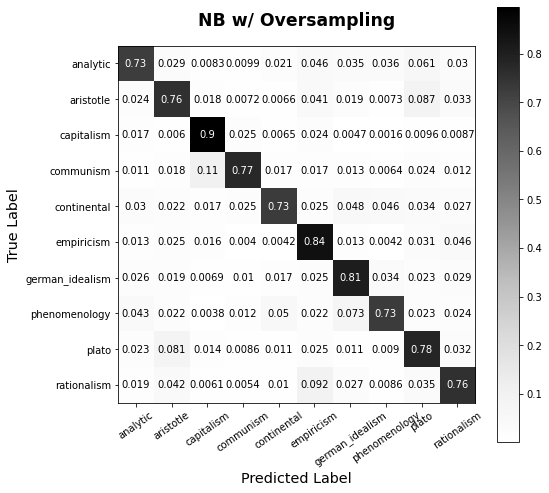

In [49]:
plot_pretty_cf(nb_undersampled, tf_idf_data_test, y_test, 
               title='NB w/ Oversampling', label_dict=flipped_dict)

In [50]:
print(classification_report(y_test, nb_oversampled_preds))

              precision    recall  f1-score   support

           0       0.85      0.73      0.78     13245
           1       0.81      0.76      0.78     12267
           2       0.76      0.90      0.82      4494
           3       0.80      0.77      0.79      4497
           4       0.84      0.73      0.78      8444
           5       0.61      0.84      0.71      5006
           6       0.81      0.81      0.81     10506
           7       0.78      0.73      0.75      7157
           8       0.71      0.78      0.75      9634
           9       0.67      0.76      0.71      5785

    accuracy                           0.77     81035
   macro avg       0.76      0.78      0.77     81035
weighted avg       0.78      0.77      0.77     81035



Unsurprisingly, not much of a different result. It seems like Multinomial Naive Bayes can give us about 77% accuracy. 

It's perhaps worth checking if lemmatization can help the model.

### NB with Lemmatization

In [51]:
x_train, x_test, y_train, y_test = train_test_split(df['lemmatized_str'], df['school'])

# vectorize
tfidvectorizer = TfidfVectorizer(decode_error='ignore', stop_words=[])
tf_idf_data_train = tfidvectorizer.fit_transform(x_train)
tf_idf_data_test = tfidvectorizer.transform(x_test)

In [52]:
y_train_dummies = pd.get_dummies(y_train)
y_classes = y_train_dummies.idxmax(1, skipna=False)

le = LabelEncoder()
le.fit(list(y_classes))
y_integers = le.transform(list(y_classes))

# create a dict of labels : their integer representations
label_dict = dict(zip(y_classes, y_integers))
flipped_dict = {value:key for key, value in label_dict.items()}

# get the class weights
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
sample_weights = compute_sample_weight('balanced', y_integers)
class_weights_dict = dict(zip(le.transform(list(le.classes_)), class_weights))

# convert the target to the numerical categories
y_train = y_train.apply(lambda x: label_dict[x])
y_test = y_test.apply(lambda x: label_dict[x])

In [53]:
rus = RandomUnderSampler(sampling_strategy='all')

x_over_lemma, y_over_lemma = rus.fit_sample(tf_idf_data_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



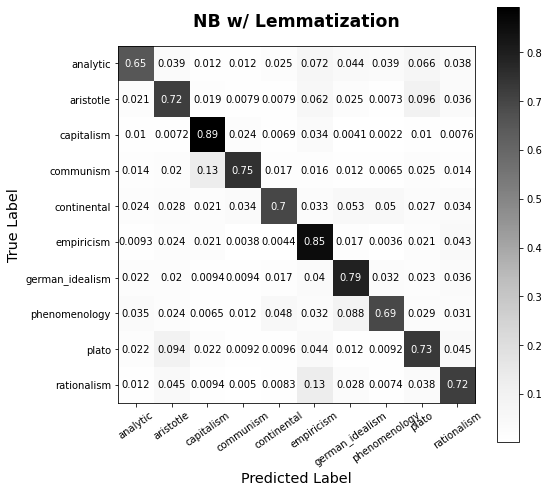

In [54]:
nb_lemma = MultinomialNB()
nb_lemma.fit(x_over_lemma, y_over_lemma)
nb_lemma_preds = nb_lemma.predict(tf_idf_data_test)

plot_pretty_cf(nb_lemma, tf_idf_data_test, y_test, 
               title='NB w/ Lemmatization', label_dict=flipped_dict)

In [55]:
print(classification_report(y_test, nb_lemma_preds))

              precision    recall  f1-score   support

           0       0.86      0.65      0.74     13370
           1       0.77      0.72      0.74     12077
           2       0.71      0.89      0.79      4612
           3       0.78      0.75      0.77      4603
           4       0.83      0.70      0.76      8593
           5       0.51      0.85      0.64      4958
           6       0.78      0.79      0.78     10528
           7       0.76      0.69      0.73      7073
           8       0.69      0.73      0.71      9566
           9       0.61      0.72      0.66      5655

    accuracy                           0.73     81035
   macro avg       0.73      0.75      0.73     81035
weighted avg       0.75      0.73      0.74     81035



Not great, and worse than non-lemmatized versions. This makes sense since lemmatization essentially masks information that might have had some small part to play in the classification math.

### NB with Bigrams

While singular words may not always be indicative of a school, certain phrases are often almost entirely exclusive to a school. So it stands to reason that incorporating bigrams into our data would help the model.

In [62]:
# vectorize, this time adjusting the ngram range to include bigrams
tfidvectorizer = TfidfVectorizer(decode_error='ignore', 
                                 stop_words=stopwords_list, 
                                 ngram_range=(1,2))
tf_idf_data_train = tfidvectorizer.fit_transform(x_train)
tf_idf_data_test = tfidvectorizer.transform(x_test)

In [63]:
y_train_dummies = pd.get_dummies(y_train)
y_classes = y_train_dummies.idxmax(1, skipna=False)

le = LabelEncoder()
le.fit(list(y_classes))
y_integers = le.transform(list(y_classes))

# create a dict of labels : their integer representations
label_dict = dict(zip(y_classes, y_integers))
flipped_dict = {value:key for key, value in label_dict.items()}

# get the class weights
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
sample_weights = compute_sample_weight('balanced', y_integers)
class_weights_dict = dict(zip(le.transform(list(le.classes_)), class_weights))

# convert the target to the numerical categories
y_train = y_train.apply(lambda x: label_dict[x])
y_test = y_test.apply(lambda x: label_dict[x])

In [64]:
rus = RandomUnderSampler(sampling_strategy='all')

x_over_bgram, y_over_bgram = rus.fit_sample(tf_idf_data_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



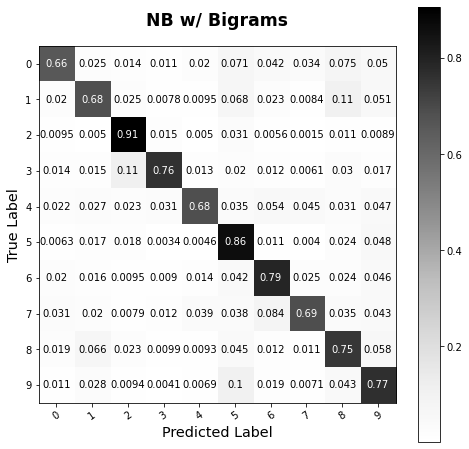

In [65]:
nb_bigrams = MultinomialNB()
nb_bigrams.fit(x_over_bgram, y_over_bgram)
nb_bigrams_preds = nb_bigrams.predict(tf_idf_data_test)

plot_pretty_cf(nb_bigrams, tf_idf_data_test, y_test, 
               title='NB w/ Bigrams', label_dict=flipped_dict)

In [66]:
print(classification_report(y_test, nb_bigrams_preds))

              precision    recall  f1-score   support

           0       0.88      0.66      0.75     13370
           1       0.82      0.68      0.74     12077
           2       0.71      0.91      0.79      4612
           3       0.80      0.76      0.78      4603
           4       0.85      0.68      0.76      8593
           5       0.51      0.86      0.64      4958
           6       0.79      0.79      0.79     10528
           7       0.77      0.69      0.73      7073
           8       0.66      0.75      0.70      9566
           9       0.56      0.77      0.65      5655

    accuracy                           0.73     81035
   macro avg       0.73      0.75      0.73     81035
weighted avg       0.76      0.73      0.74     81035



It seems like bigrams actually made the model worse. Let's try something totally different - random forests!

### Random Forest Classifier

Random Forests don't always do well on this kind of task, but it's perhaps worth trying. We'll just do an untuned model to see if it gets any kind of results worth exploring. 

In [68]:
x_train, x_test, y_train, y_test = train_test_split(df['sentence_str'], df['school'])

# vectorize
tfidvectorizer = TfidfVectorizer(decode_error='ignore', 
                                 stop_words=custom_stopwords)
tf_idf_data_train = tfidvectorizer.fit_transform(x_train)
tf_idf_data_test = tfidvectorizer.transform(x_test)

y_train_dummies = pd.get_dummies(y_train)
y_classes = y_train_dummies.idxmax(1, skipna=False)

le = LabelEncoder()
le.fit(list(y_classes))
y_integers = le.transform(list(y_classes))

# create a dict of labels : their integer representations
label_dict = dict(zip(y_classes, y_integers))
flipped_dict = {value:key for key, value in label_dict.items()}

# get the class weights
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
sample_weights = compute_sample_weight('balanced', y_integers)
class_weights_dict = dict(zip(le.transform(list(le.classes_)), class_weights))

# convert the target to the numerical categories
y_train = y_train.apply(lambda x: label_dict[x])
y_test = y_test.apply(lambda x: label_dict[x])

In [69]:
rus = RandomUnderSampler(sampling_strategy='all')

x_over, y_over = rus.fit_sample(tf_idf_data_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



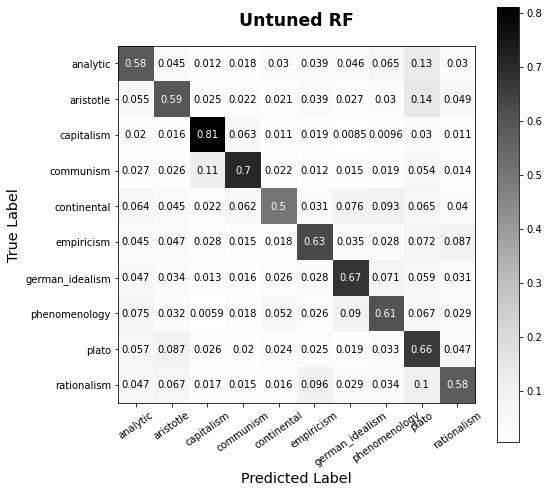

In [70]:
rf = RandomForestClassifier()
rf.fit(x_over, y_over)
rf_preds = rf.predict(tf_idf_data_test)

plot_pretty_cf(rf, tf_idf_data_test, y_test, 
               title='Untuned RF', label_dict=flipped_dict)

In [71]:
print(classification_report(y_test, rf_preds))

              precision    recall  f1-score   support

           0       0.69      0.58      0.63     13343
           1       0.69      0.59      0.64     12122
           2       0.67      0.81      0.73      4573
           3       0.62      0.70      0.66      4499
           4       0.69      0.50      0.58      8328
           5       0.54      0.63      0.58      5087
           6       0.71      0.67      0.69     10545
           7       0.55      0.61      0.58      7092
           8       0.50      0.66      0.57      9637
           9       0.54      0.58      0.56      5809

    accuracy                           0.62     81035
   macro avg       0.62      0.63      0.62     81035
weighted avg       0.63      0.62      0.62     81035



Unfortunately the random forest model did worse than any Bayesian model. A result like this is poor enough that spending time refining it may just not be worth the effort, especially when there are more promising avenues still to explore. 

Overall, the Bayesian models were able to reach 77% accuracy when corrected for class imbalance. When one takes into account the number of classes (10) involved, that is a respectable result.

Our next step is to explore neural network models and see if we can improve on this accuracy score.